In [ ]:
import warnings
warnings.filterwarnings('ignore')

**СЕГМЕНТАЦІЯ КЛІЄНТІВ**

In [ ]:
import pandas as pd

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Gender,Age,Salary
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Male,29,30000
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Female,69,44000
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Male,47,106000
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Male,70,62000
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Male,68,35000


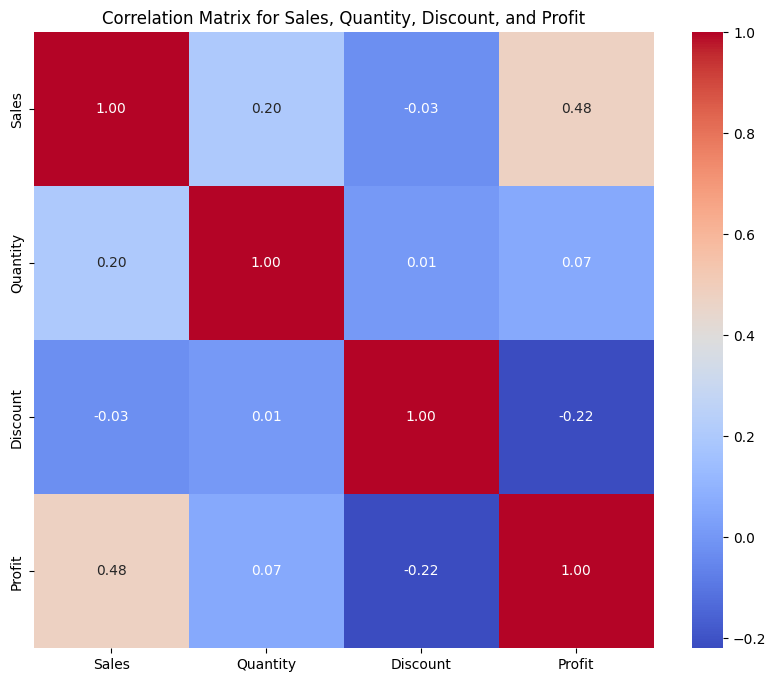

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_fields = ['Sales', 'Quantity', 'Discount', 'Profit']

correlation_matrix_filtered = data[numeric_fields].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for Sales, Quantity, Discount, and Profit')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])


data['Order Date Numeric'] = (data['Order Date'] - data['Order Date'].min()).dt.days
data['Ship Date Numeric'] = (data['Ship Date'] - data['Ship Date'].min()).dt.days


encoder = LabelEncoder()
data['Segment Encoded'] = encoder.fit_transform(data['Segment'])
data['Ship Mode Encoded'] = encoder.fit_transform(data['Ship Mode'])


data[['Order Date Numeric', 'Ship Date Numeric', 'Segment Encoded', 'Ship Mode Encoded']].head()


,Order Date Numeric,Ship Date Numeric,Segment Encoded,Ship Mode Encoded
0,1040,1039,0,2
1,1040,1039,0,2
2,891,891,1,2
3,647,650,0,3
4,647,650,0,3


In [ ]:

most_recent_purchase = data['Order Date'].max()


recency = data.groupby('Customer ID')['Order Date'].max().reset_index()
recency['Recency'] = (most_recent_purchase - recency['Order Date']).dt.days

frequency = data.groupby('Customer ID').size().reset_index(name='Frequency')

monetary = data.groupby('Customer ID')['Sales'].sum().reset_index(name='Monetary')


rfm = recency[['Customer ID', 'Recency']].merge(frequency, on='Customer ID').merge(monetary, on='Customer ID')
rfm.head()


,Customer ID,Recency,Frequency,Monetary
0,AA-10315,184,11,5563.560
1,AA-10375,19,15,1056.390
2,AA-10480,259,12,1790.512
3,AA-10645,55,18,5086.935
4,AB-10015,415,6,886.156


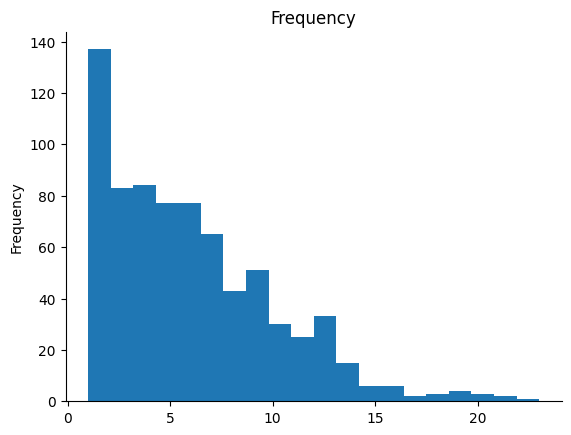

In [ ]:
from matplotlib import pyplot as plt
rfm['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

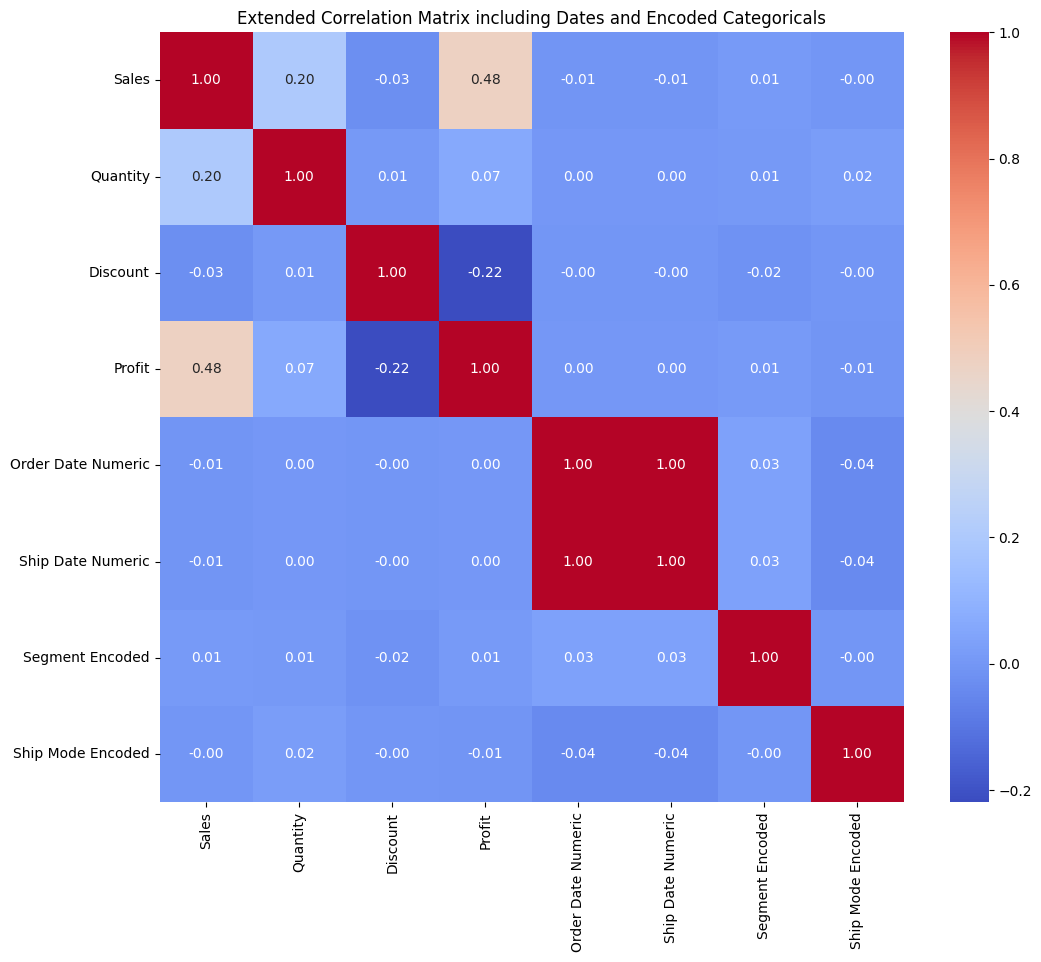

In [ ]:
selected_fields = numeric_fields + ['Order Date Numeric', 'Ship Date Numeric', 'Segment Encoded', 'Ship Mode Encoded']

extended_correlation_matrix = data[selected_fields].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(extended_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Extended Correlation Matrix including Dates and Encoded Categoricals')
plt.show()


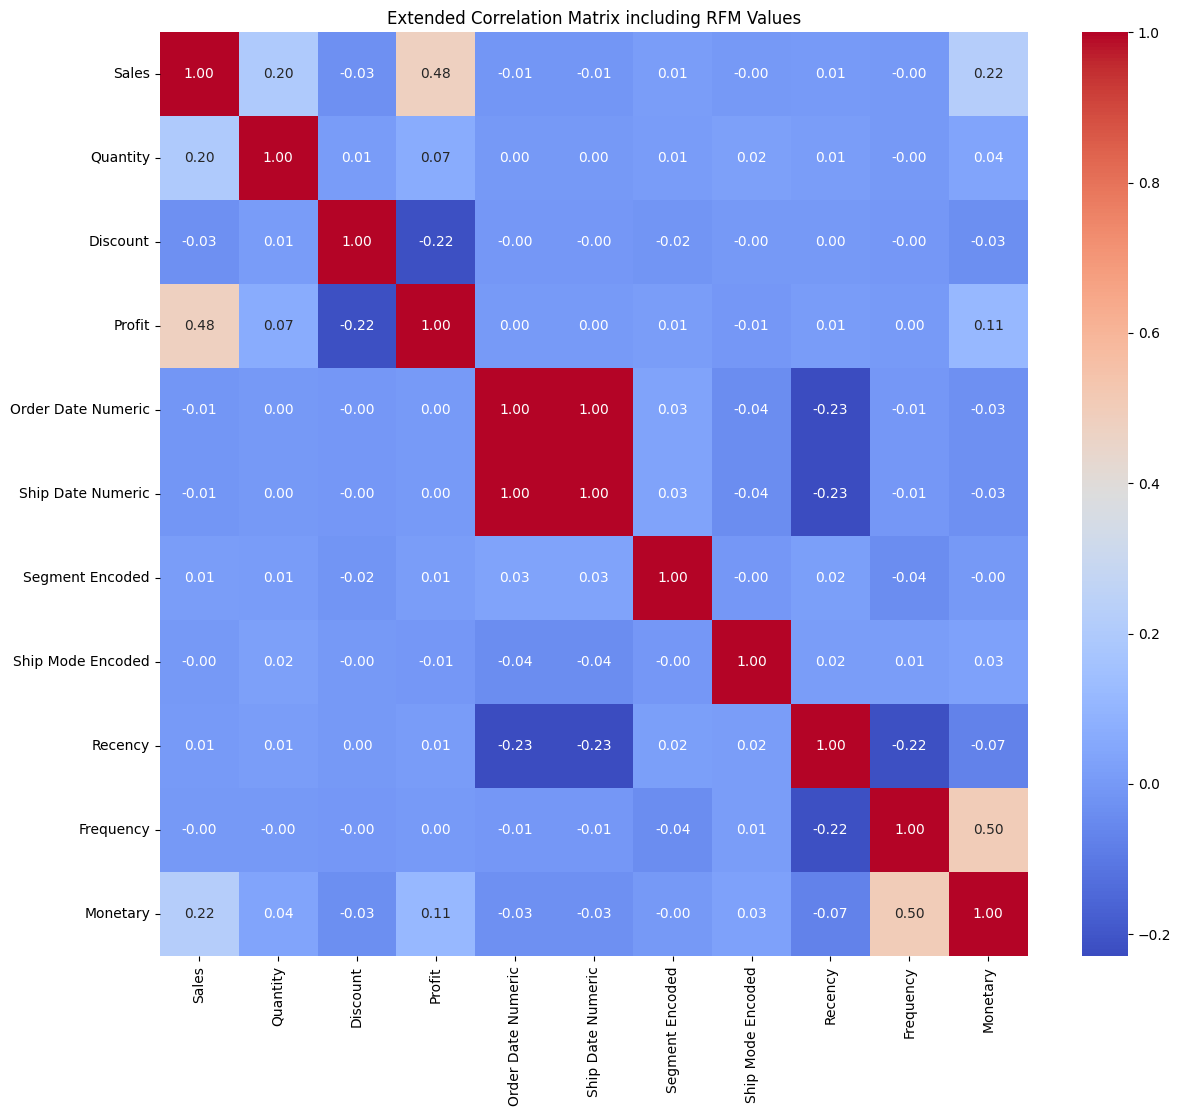

In [ ]:
data_with_rfm = data.merge(rfm, on='Customer ID', how='left')

data_with_rfm[['Customer ID', 'Recency', 'Frequency', 'Monetary']].head()

selected_fields_with_rfm = selected_fields + ['Recency', 'Frequency', 'Monetary']
extended_correlation_matrix_with_rfm = data_with_rfm[selected_fields_with_rfm].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(extended_correlation_matrix_with_rfm, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Extended Correlation Matrix including RFM Values')
plt.show()


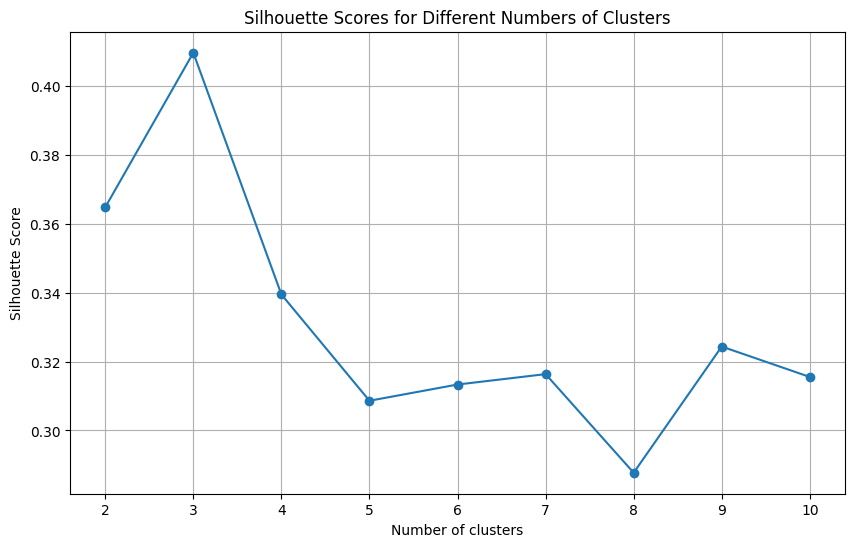

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

rfm_features = data_with_rfm[['Recency', 'Frequency', 'Monetary']].values

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)


silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, kmeans.labels_)
    silhouette_scores.append(score)


plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.grid(True)
plt.show()


In [ ]:

optimal_clusters = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]


kmeans_optimal = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_optimal.fit(rfm_scaled)


data_with_rfm['Cluster'] = kmeans_optimal.labels_
data_with_rfm.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Age,Salary,Order Date Numeric,Ship Date Numeric,Segment Encoded,Ship Mode Encoded,Recency,Frequency,Monetary,Cluster
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,29,30000,1040,1039,0,2,338,5,1148.7800,2
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,69,44000,1040,1039,0,2,338,5,1148.7800,2
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,47,106000,891,891,1,2,19,9,1119.4830,0
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,70,62000,647,650,0,3,29,15,2602.5755,0
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,68,35000,647,650,0,3,29,15,2602.5755,0


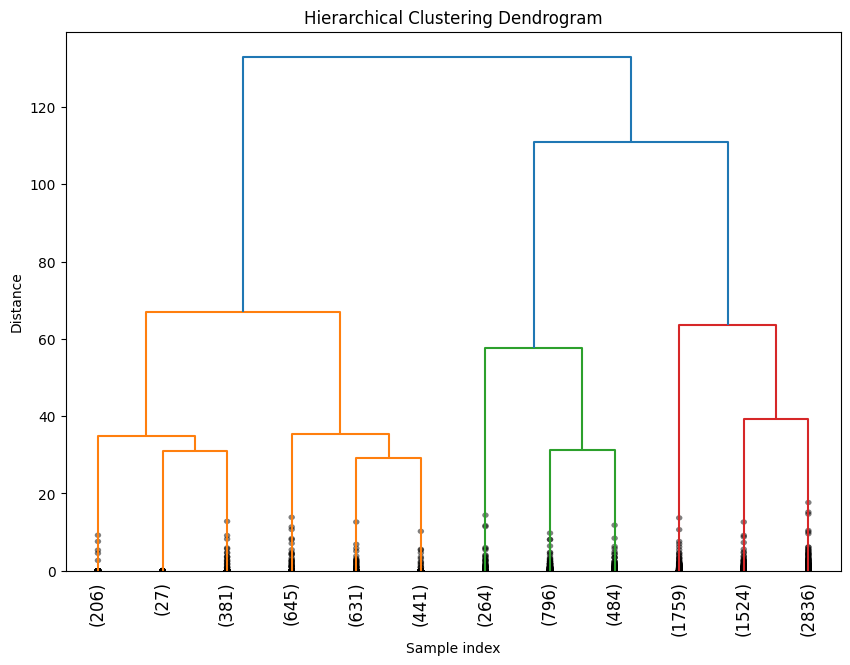

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(rfm_scaled, 'ward')


plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

n_clusters = 5
clusters_hc = fcluster(Z, n_clusters, criterion='maxclust')

data_with_rfm['Cluster_HC'] = clusters_hc
data_with_rfm.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Salary,Order Date Numeric,Ship Date Numeric,Segment Encoded,Ship Mode Encoded,Recency,Frequency,Monetary,Cluster,Cluster_HC
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,30000,1040,1039,0,2,338,5,1148.7800,2,3
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,44000,1040,1039,0,2,338,5,1148.7800,2,3
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,106000,891,891,1,2,19,9,1119.4830,0,4
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,62000,647,650,0,3,29,15,2602.5755,0,5
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,35000,647,650,0,3,29,15,2602.5755,0,5


<ipython-input-13-95a9f6fbecfb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_types[0], y=feature, data=rfm_visualization, ax=axes[2*i], palette="Set3").set_title(f'K-Means: {feature}')
<ipython-input-13-95a9f6fbecfb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_types[1], y=feature, data=rfm_visualization, ax=axes[2*i+1], palette="Set2").set_title(f'Hierarchical: {feature}')
<ipython-input-13-95a9f6fbecfb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cluster_types[0], y=feature, data=rfm_visualization, ax=

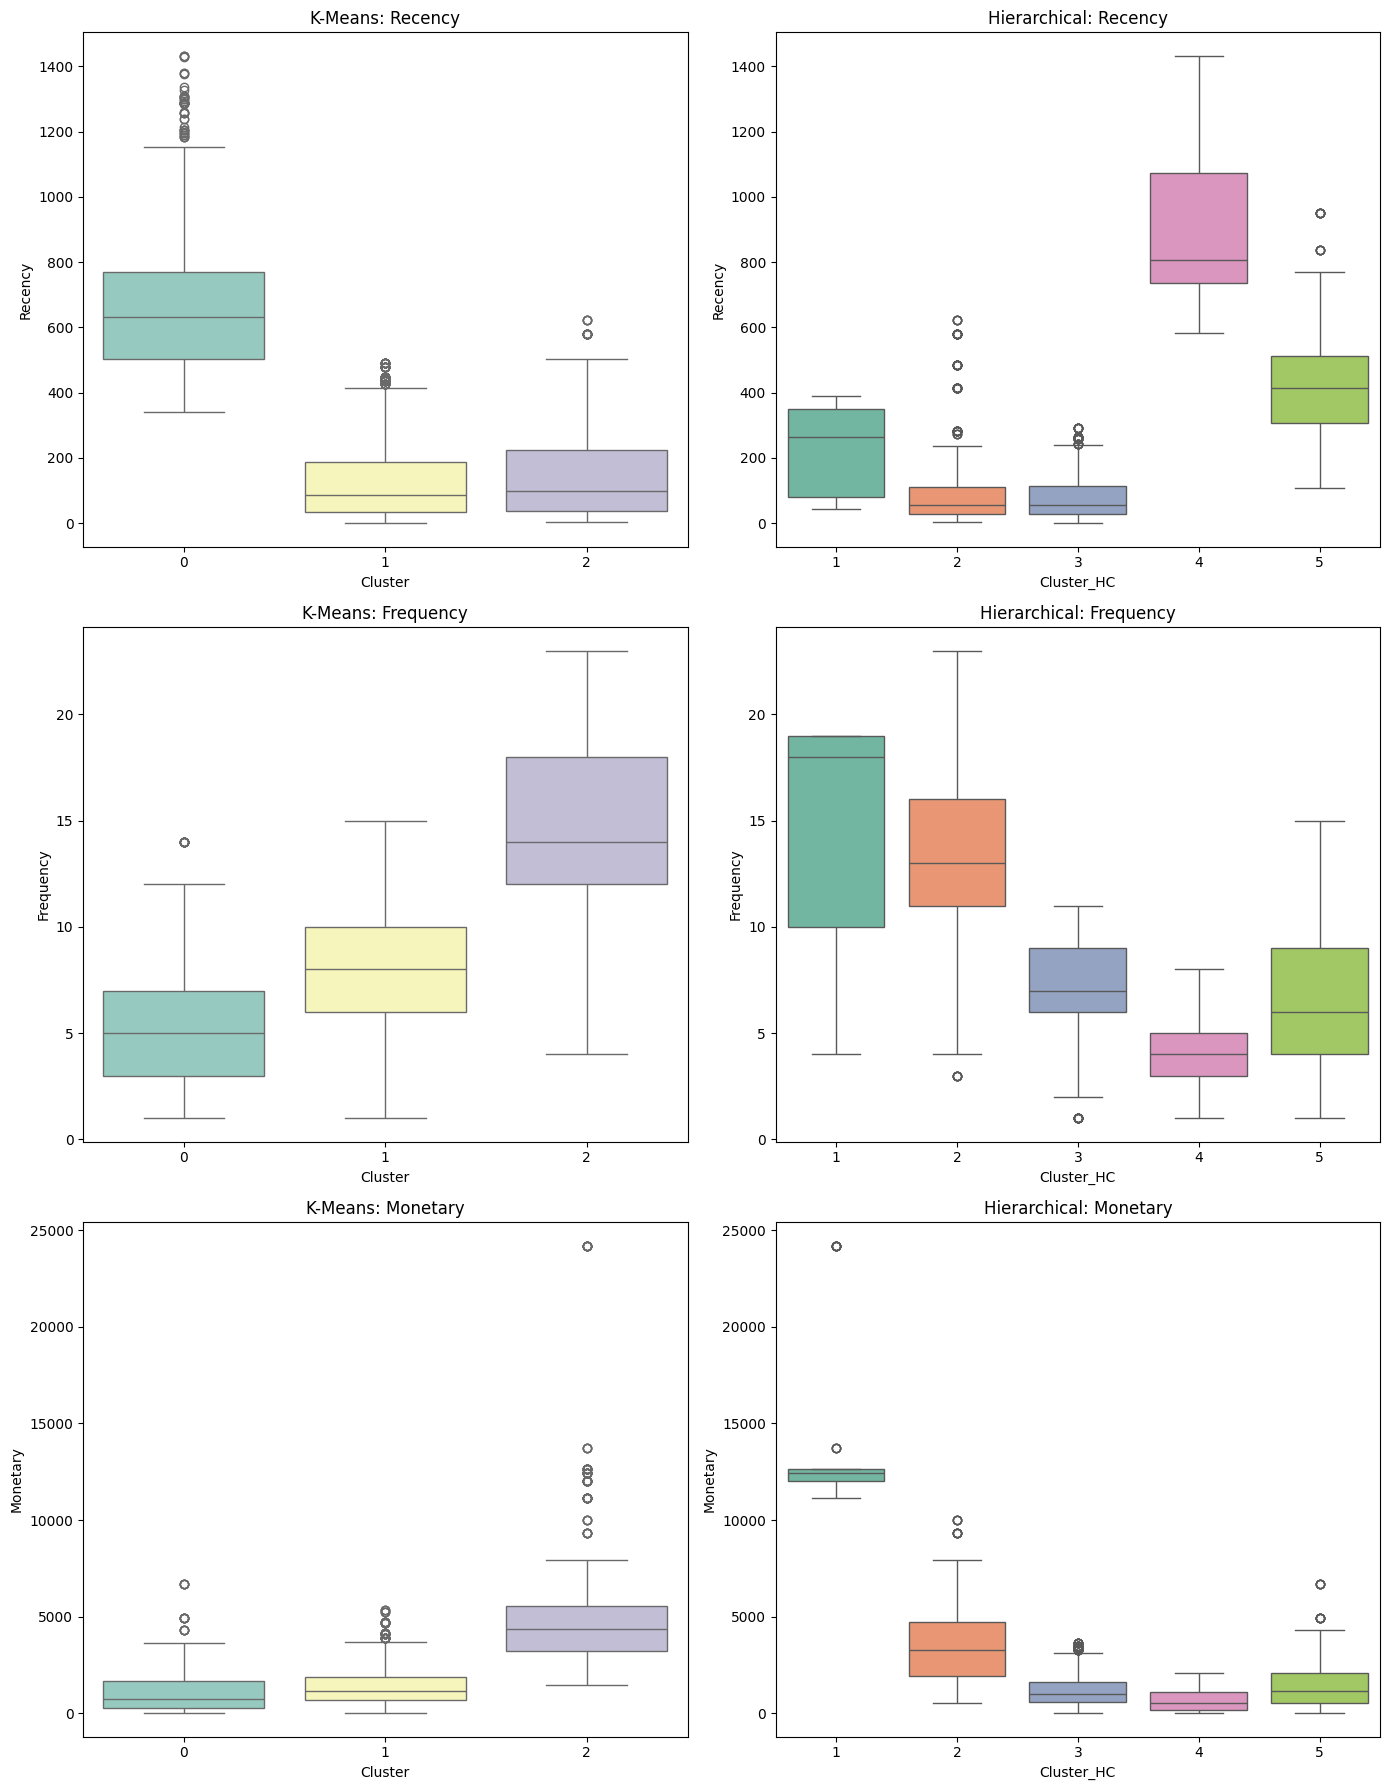

In [ ]:
rfm_visualization = data_with_rfm.copy()


fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

features = ['Recency', 'Frequency', 'Monetary']
cluster_types = ['Cluster', 'Cluster_HC']

for i, feature in enumerate(features):
    sns.boxplot(x=cluster_types[0], y=feature, data=rfm_visualization, ax=axes[2*i], palette="Set3").set_title(f'K-Means: {feature}')
    sns.boxplot(x=cluster_types[1], y=feature, data=rfm_visualization, ax=axes[2*i+1], palette="Set2").set_title(f'Hierarchical: {feature}')

plt.tight_layout()
plt.show()


In [ ]:
data_with_rfm.size

137340

In [ ]:
data.size

114450

ВИБІР ОЗНАК

In [ ]:
import pandas as pd

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Gender,Age,Salary
0,1,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Male,29,30000
1,2,CA-2021-152156,2021-11-08,2021-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Female,69,44000
2,3,CA-2021-138688,2021-06-12,2021-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Male,47,106000
3,4,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Male,70,62000
4,5,US-2020-108966,2020-10-11,2020-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Male,68,35000


In [ ]:
from sklearn.feature_selection import VarianceThreshold

features = data[['Sales', 'Quantity', 'Discount', 'Profit']]

thresholder = VarianceThreshold(threshold=(.01 * (1 - .01)))
filtered_features = thresholder.fit_transform(features)

filtered_features.shape


(9994, 4)

**DENDROGRAM**

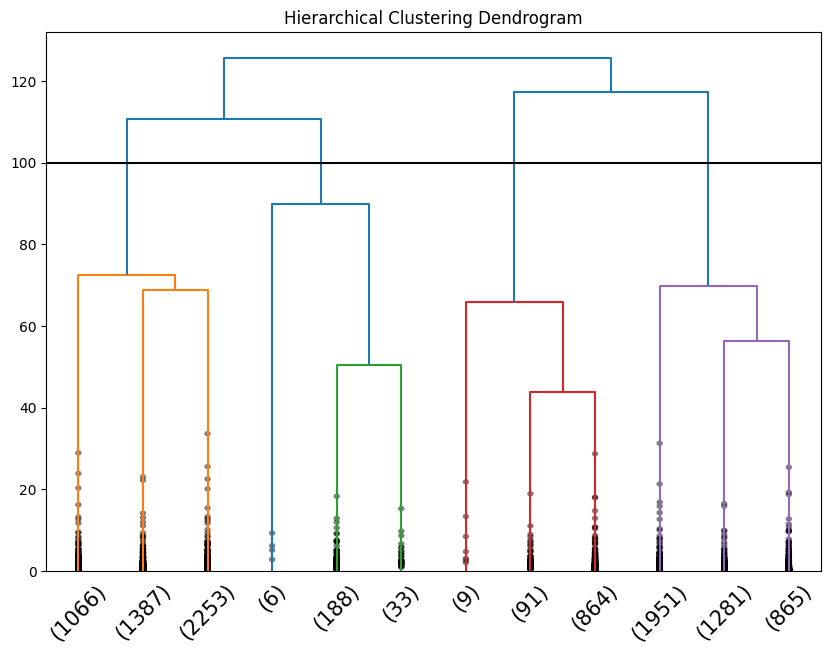

3

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

numeric_data = data.select_dtypes(include=[np.number])

normalized_data = (numeric_data - numeric_data.mean()) / numeric_data.std()

Z = linkage(normalized_data, method='ward')


plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)

max_d = 100
plt.axhline(y=max_d, c='k')
plt.show()

clusters = sum(1 for h in Z[:, 2] if h >= max_d)
clusters


In [ ]:
[(1, h, max_d) for h in Z[:, 2]]

[(1, 0.00034660079238302277, 80),
 (1, 0.0007825184017340177, 80),
 (1, 0.0008412893840907063, 80),
 (1, 0.001070617532621973, 80),
 (1, 0.0012765172673763316, 80),
 (1, 0.0012942516796292827, 80),
 (1, 0.0019421215943924296, 80),
 (1, 0.0021766350956316178, 80),
 (1, 0.0024154997960872376, 80),
 (1, 0.0024172988020135762, 80),
 (1, 0.0025051043833958617, 80),
 (1, 0.002674209378315209, 80),
 (1, 0.002885049251964834, 80),
 (1, 0.0029688335107498315, 80),
 (1, 0.003294661589940024, 80),
 (1, 0.0033051941261536453, 80),
 (1, 0.003338842555937783, 80),
 (1, 0.0034561629812501315, 80),
 (1, 0.003510608602659321, 80),
 (1, 0.0035394578834886063, 80),
 (1, 0.0036311633616341794, 80),
 (1, 0.0036459177857581008, 80),
 (1, 0.0036777578867697607, 80),
 (1, 0.0037099569015637763, 80),
 (1, 0.003813756599709959, 80),
 (1, 0.0038807026071220373, 80),
 (1, 0.0040225948809437875, 80),
 (1, 0.0040463083575296354, 80),
 (1, 0.004055976888488901, 80),
 (1, 0.004169926425193649, 80),
 (1, 0.00431653474

**K-MEANS + RFM**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

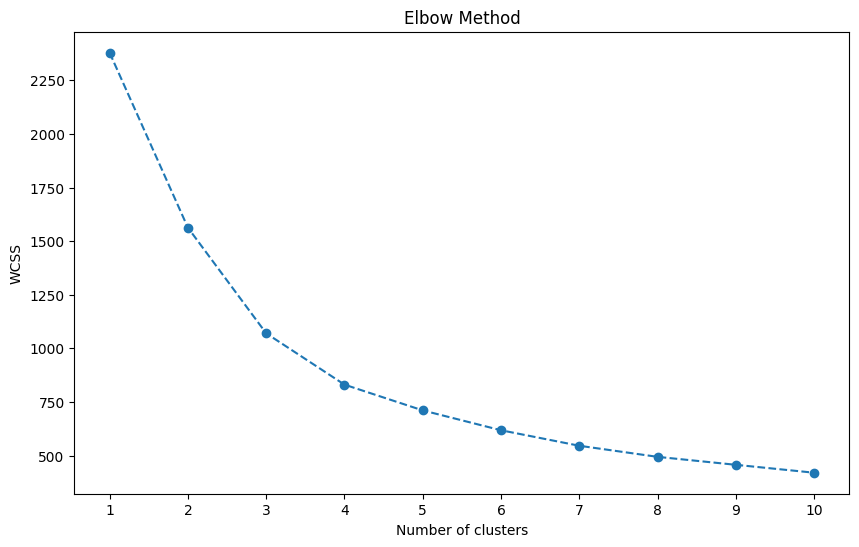

Optimal number of clusters: 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')
data['Order Date'] = pd.to_datetime(data['Order Date'])


today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

diff = np.diff(wcss)
diff_r = diff[1:] / diff[:-1]
k_optimal = np.argmin(diff_r) + 2


plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.show()

print("Optimal number of clusters:", k_optimal)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

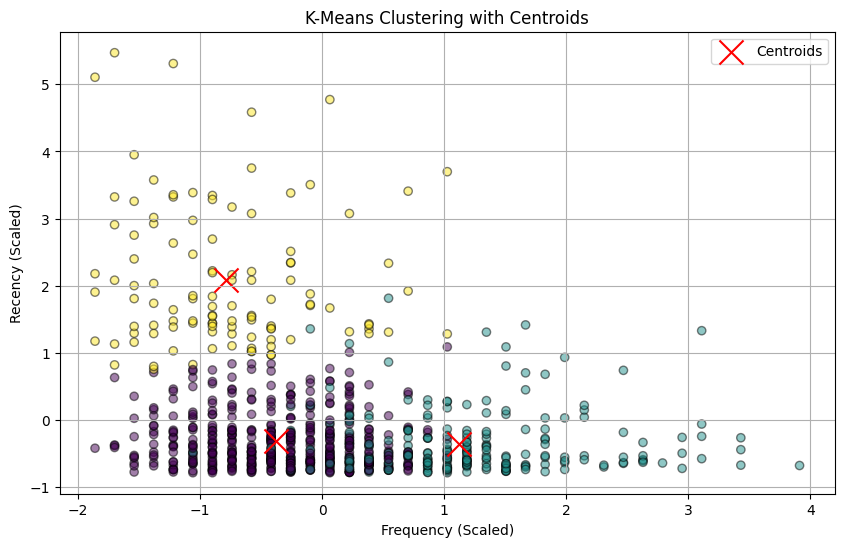

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')


data['Order Date'] = pd.to_datetime(data['Order Date'])


today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)


diff = np.diff(wcss)
diff_r = diff[1:] / diff[:-1]
k_optimal = np.argmin(diff_r) + 2


kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(rfm_scaled)
rfm_data['Cluster'] = kmeans.labels_

data_with_cluster = pd.merge(data, rfm_data[['Customer ID', 'Cluster']], on='Customer ID', how='left')

data_with_cluster.to_csv("data_with_cluster.csv", index=False)

plt.figure(figsize=(10, 6))


plt.scatter(rfm_scaled[:,1], rfm_scaled[:,0], c=kmeans.labels_, cmap='viridis', alpha=0.5, edgecolor='k')
plt.xlabel('Frequency (Scaled)')
plt.ylabel('Recency (Scaled)')


plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], c='red', marker='x', s=300, label='Centroids')
plt.title('K-Means Clustering with Centroids')
plt.legend()
plt.grid(True)
plt.show()


**MINI BATCH K-MEANS + RFM**

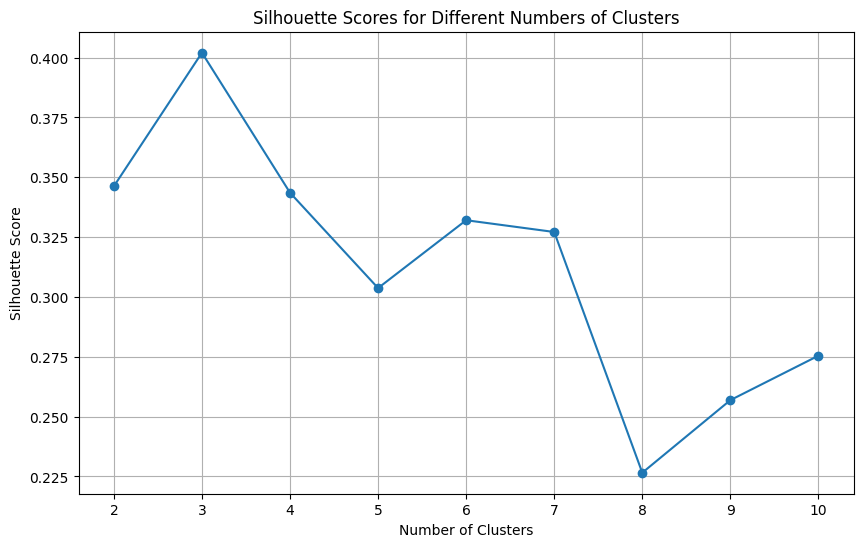

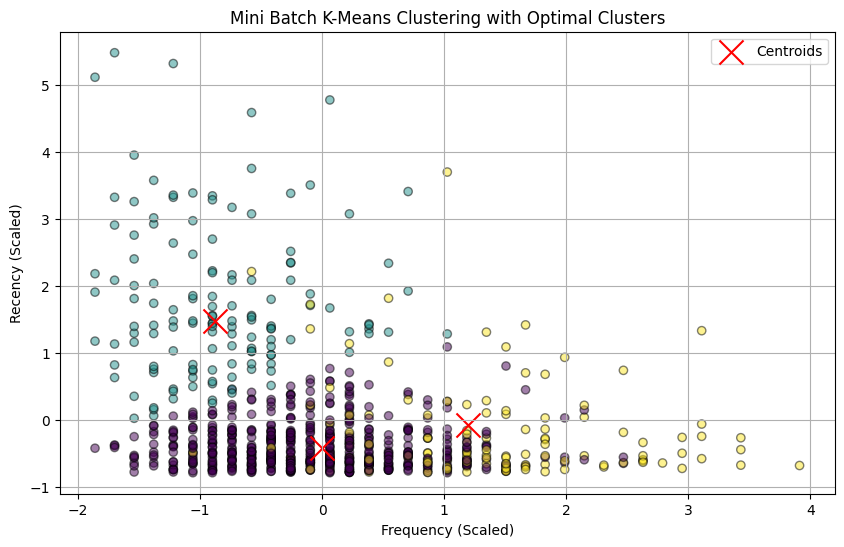

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data['Order Date'] = pd.to_datetime(data['Order Date'])

today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date': 'Recency', 'Order ID': 'Frequency', 'Sales': 'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

silhouette_scores = []
batch_size = 100
for i in range(2, 11):
    mbk = MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=batch_size, random_state=42)
    mbk.fit(rfm_scaled)
    score = silhouette_score(rfm_scaled, mbk.labels_)
    silhouette_scores.append(score)


plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


k_optimal = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]


mbk = MiniBatchKMeans(n_clusters=k_optimal, random_state=42, batch_size=batch_size)
mbk.fit(rfm_scaled)
rfm_data['Cluster'] = mbk.labels_


data_with_cluster = pd.merge(data, rfm_data[['Customer ID', 'Cluster']], on='Customer ID', how='left')


data_with_cluster.to_csv("data_with_cluster.csv", index=False)


plt.figure(figsize=(10, 6))


plt.scatter(rfm_scaled[:,1], rfm_scaled[:,0], c=mbk.labels_, cmap='viridis', alpha=0.5, edgecolor='k')
plt.xlabel('Frequency (Scaled)')
plt.ylabel('Recency (Scaled)')


plt.scatter(mbk.cluster_centers_[:, 1], mbk.cluster_centers_[:, 0], c='red', marker='x', s=300, label='Centroids')
plt.title('Mini Batch K-Means Clustering with Optimal Clusters')
plt.legend()
plt.grid(True)
plt.show()


**AFFINITY PROPAGATION + RFM**

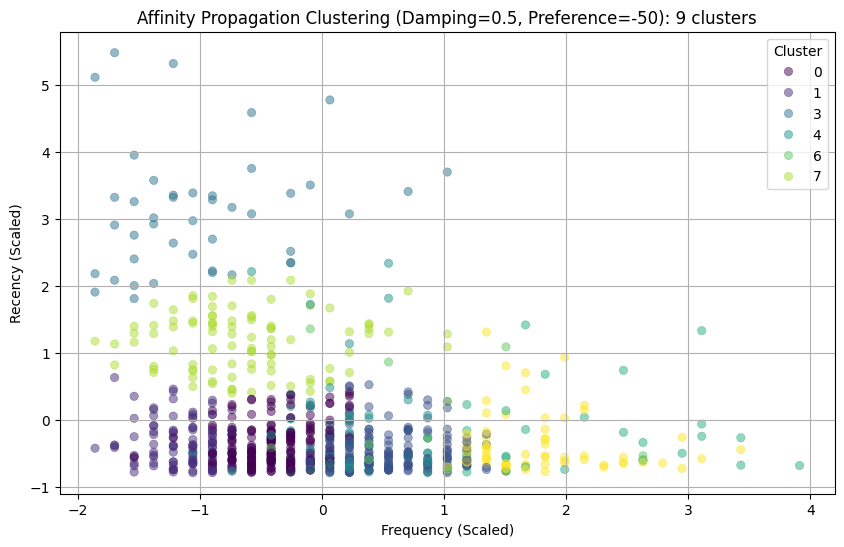

Number of clusters (Damping=0.5, Preference=-50): 9


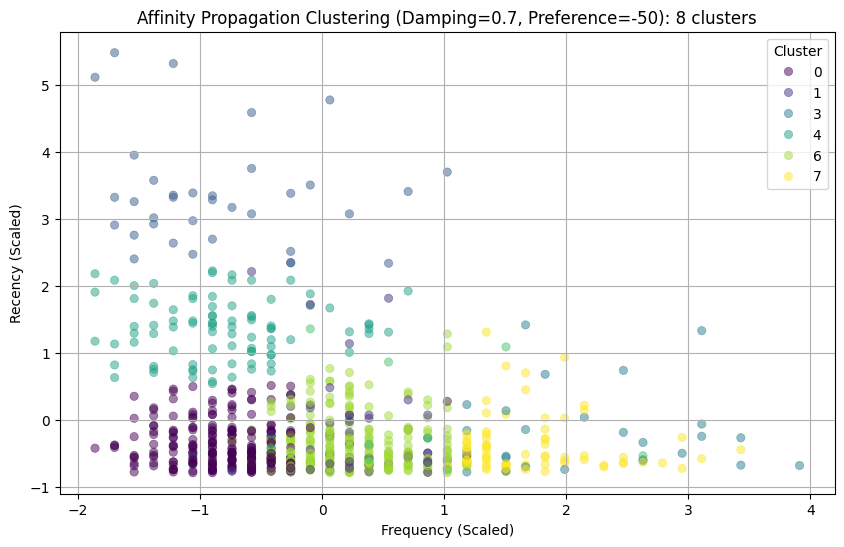

Number of clusters (Damping=0.7, Preference=-50): 8


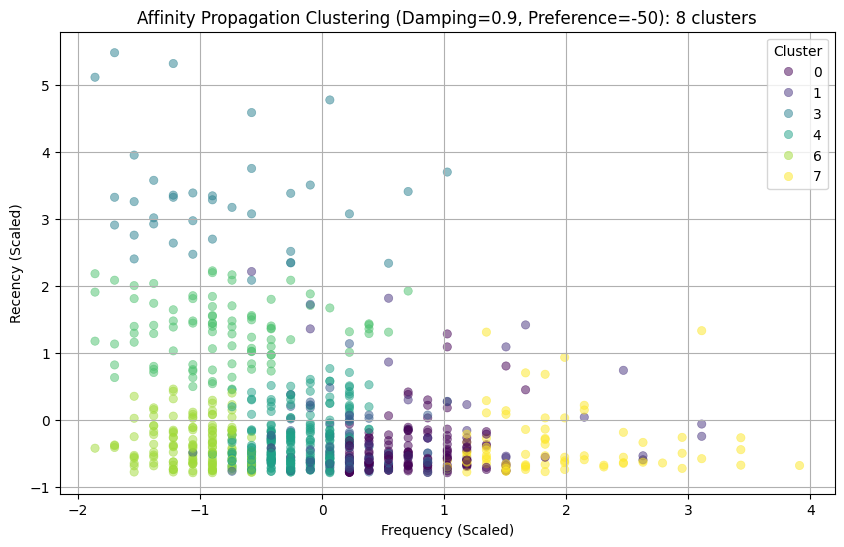

Number of clusters (Damping=0.9, Preference=-50): 8


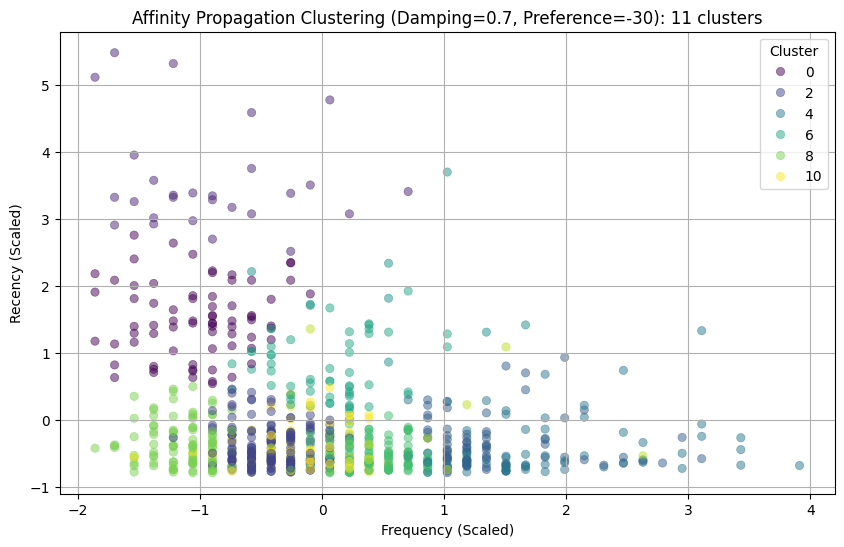

Number of clusters (Damping=0.7, Preference=-30): 11


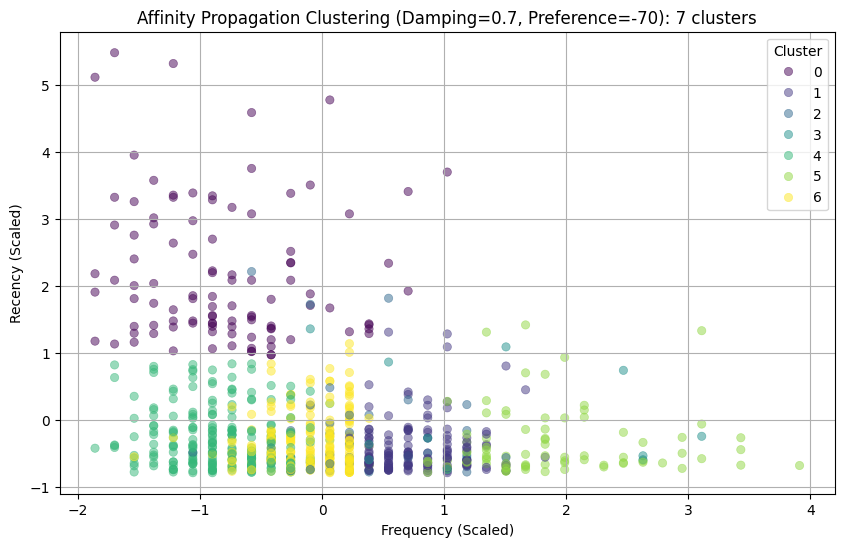

Number of clusters (Damping=0.7, Preference=-70): 7


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')
data['Order Date'] = pd.to_datetime(data['Order Date'])


today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])


parameters = [(0.5, -50), (0.7, -50), (0.9, -50), (0.7, -30), (0.7, -70)]

for damping, preference in parameters:
    affinity_propagation = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    affinity_propagation.fit(rfm_scaled)
    rfm_data['Cluster'] = affinity_propagation.labels_

    
    num_clusters = len(np.unique(affinity_propagation.labels_))
    
    
    plt.figure(figsize=(10, 6))

    sns.scatterplot(x=rfm_scaled[:,1], y=rfm_scaled[:,0], hue=affinity_propagation.labels_,
                    palette='viridis', alpha=0.5, edgecolor=None)
    plt.xlabel('Frequency (Scaled)')
    plt.ylabel('Recency (Scaled)')
    plt.title(f'Affinity Propagation Clustering (Damping={damping}, Preference={preference}): {num_clusters} clusters')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(True)
    plt.show()

    print(f'Number of clusters (Damping={damping}, Preference={preference}): {num_clusters}')


**HIERARCHICAL + RFM**

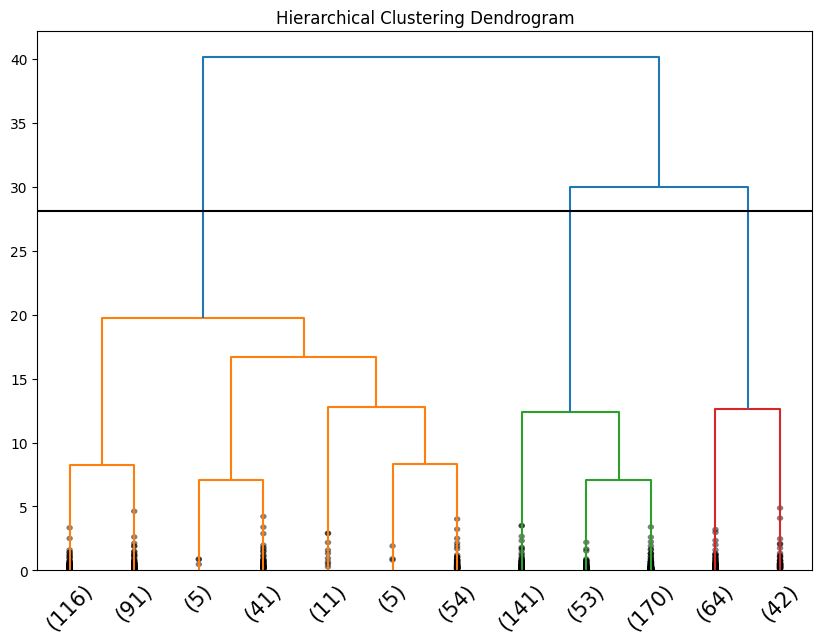

Optimal number of clusters: 766


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data['Order Date'] = pd.to_datetime(data['Order Date'])

today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

linked = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linked, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=15., show_contracted=True)

max_d = 0.7 * max(linked[:, 2])
plt.axhline(y=max_d, c='k')
plt.show()

clusters = sum(1 for h in linked[:, 2] if h >= max_d)
clusters

print("Optimal number of clusters:", optimal_clusters)

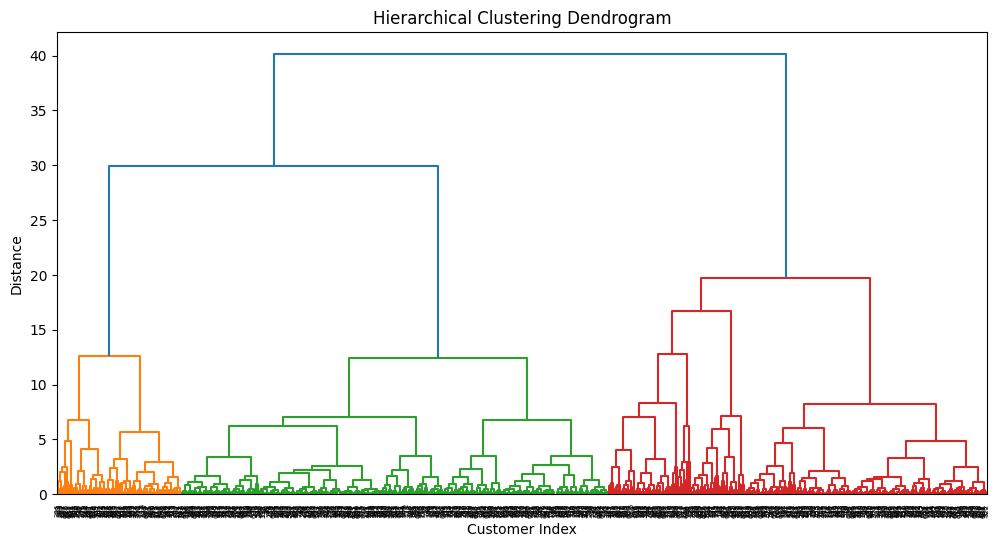

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data['Order Date'] = pd.to_datetime(data['Order Date'])

today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

linked = linkage(rfm_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()


optimal_num_clusters = 3
cluster_labels = fcluster(linked, optimal_num_clusters, criterion='maxclust')

rfm_data['Cluster'] = cluster_labels

data_with_cluster = pd.merge(data, rfm_data[['Customer ID', 'Cluster']], on='Customer ID', how='left')

data_with_cluster.to_csv("your_data_with_cluster.csv", index=False)

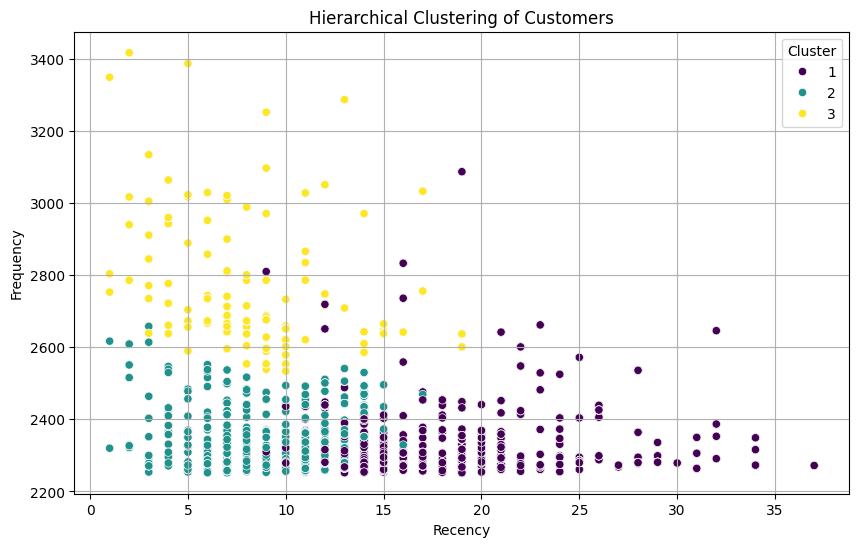

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data['Order Date'] = pd.to_datetime(data['Order Date'])

today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

linked = linkage(rfm_scaled, method='ward')

optimal_num_clusters = 3
cluster_labels = fcluster(linked, optimal_num_clusters, criterion='maxclust')

rfm_data['Cluster'] = cluster_labels

data_with_cluster = pd.merge(data, rfm_data, on='Customer ID', how='left')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_with_cluster, x='Frequency', y='Recency', hue='Cluster', palette='viridis', legend='full')
plt.title('Hierarchical Clustering of Customers')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

**Data Representation**

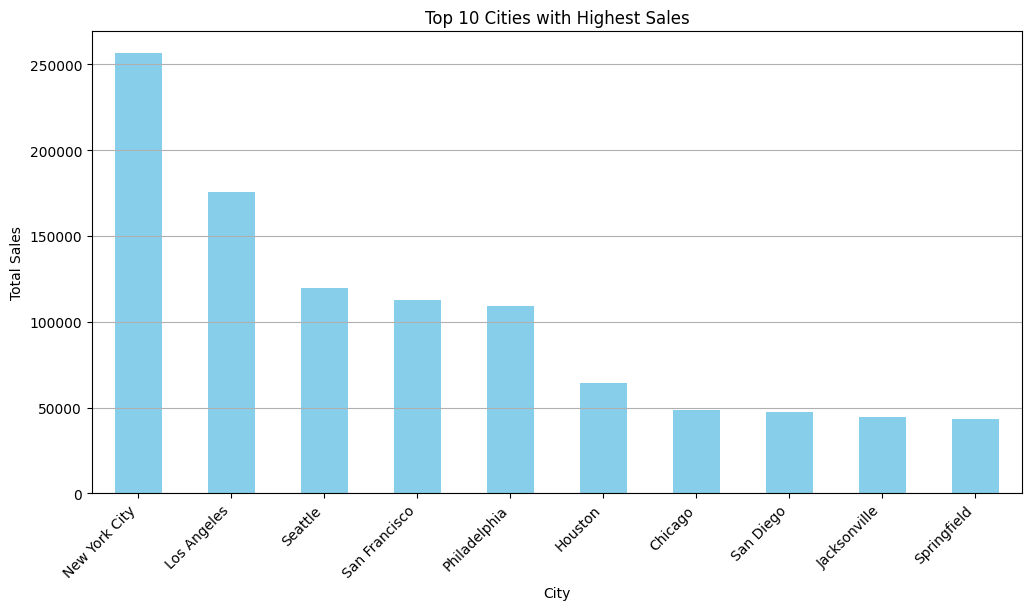

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')


city_sales = data.groupby('City')['Sales'].sum().sort_values(ascending=False)

top_10_cities = city_sales.head(10)


plt.figure(figsize=(12, 6))
top_10_cities.plot(kind='bar', color='skyblue')
plt.title('Top 10 Cities with Highest Sales')
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


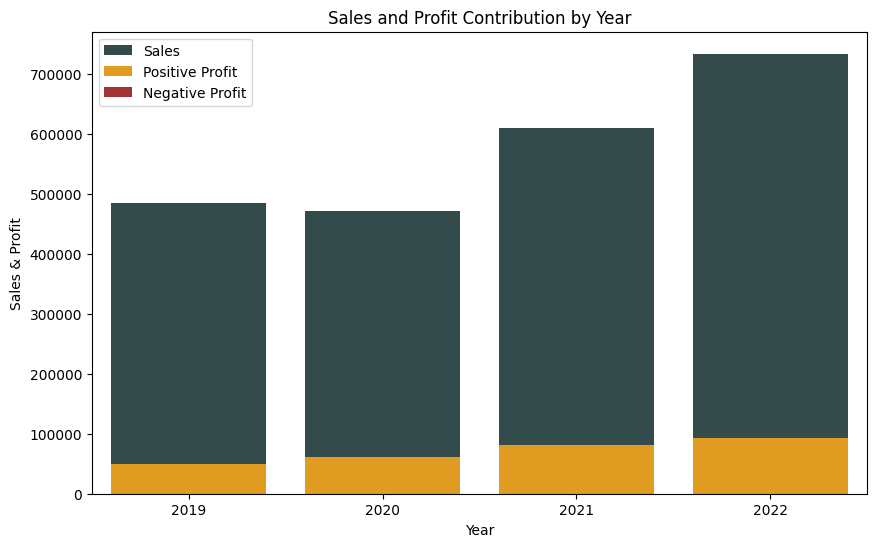

In [ ]:

data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Year'] = data['Order Date'].dt.year


year_grouped = data.groupby('Year').agg({'Sales':'sum', 'Profit':'sum'}).reset_index()


year_grouped['Positive Profit'] = year_grouped['Profit'].apply(lambda x: x if x > 0 else 0)
year_grouped['Negative Profit'] = year_grouped['Profit'].apply(lambda x: x if x < 0 else 0)

plt.figure(figsize=(10, 6))


sns.barplot(x='Year', y='Sales', data=year_grouped, color='darkslategrey', label='Sales')


sns.barplot(x='Year', y='Positive Profit', data=year_grouped, color='orange', label='Positive Profit')


sns.barplot(x='Year', y='Negative Profit', data=year_grouped, color='firebrick', label='Negative Profit')

plt.ylabel('Sales & Profit')
plt.title('Sales and Profit Contribution by Year')
plt.legend()
plt.show()


ОЦІНКА КЛАСТЕРИЗАЦІЇ ЗА ДОПОМОГОЮ МЕТОДУ СИЛУЕТУ

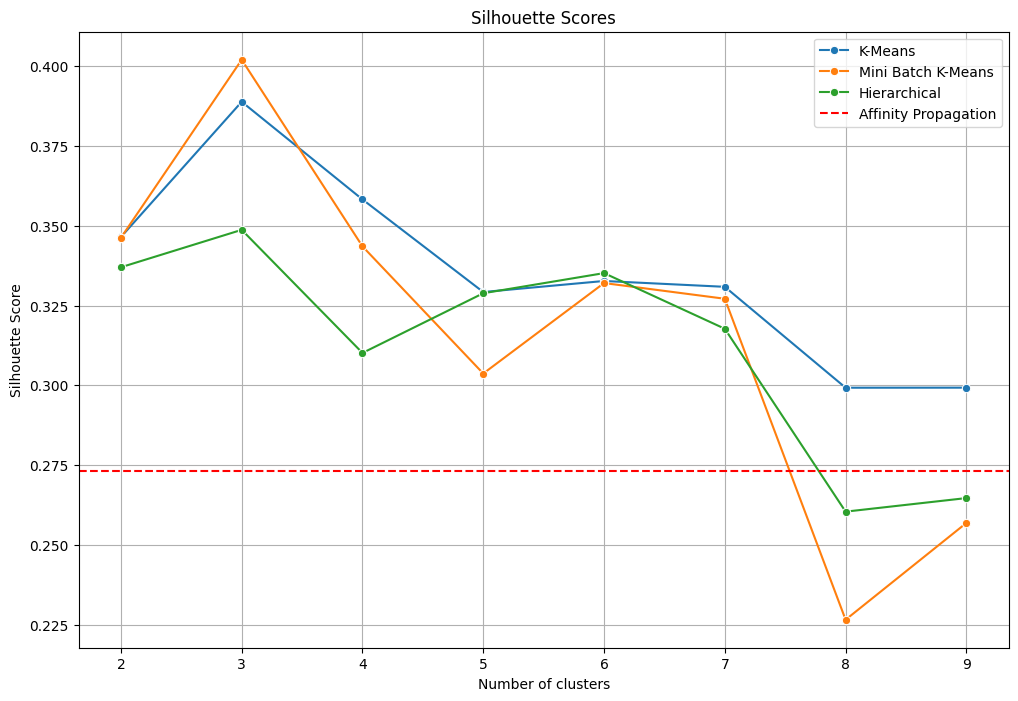

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, AffinityPropagation
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples

data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')

data['Order Date'] = pd.to_datetime(data['Order Date'])

# Calculate RFM scores
today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

silhouette_scores_kmeans = []
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(rfm_scaled)
    silhouette_scores_kmeans.append(silhouette_score(rfm_scaled, kmeans_labels))


silhouette_scores_minibatch = []
for n_clusters in range(2, 10):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
    minibatch_labels = minibatch_kmeans.fit_predict(rfm_scaled)
    silhouette_scores_minibatch.append(silhouette_score(rfm_scaled, minibatch_labels))


silhouette_scores_hierarchical = []
for n_clusters in range(2, 10):
    linked = linkage(rfm_scaled, method='ward')
    hierarchical_labels = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_scores_hierarchical.append(silhouette_score(rfm_scaled, hierarchical_labels))


affinity_propagation = AffinityPropagation(damping=0.5, preference=-50, random_state=42)
affinity_labels = affinity_propagation.fit_predict(rfm_scaled)
silhouette_score_affinity = silhouette_score(rfm_scaled, affinity_labels)


plt.figure(figsize=(12, 8))

sns.lineplot(x=range(2, 10), y=silhouette_scores_kmeans, marker='o', label='K-Means')
sns.lineplot(x=range(2, 10), y=silhouette_scores_minibatch, marker='o', label='Mini Batch K-Means')
sns.lineplot(x=range(2, 10), y=silhouette_scores_hierarchical, marker='o', label='Hierarchical')
plt.axhline(y=silhouette_score_affinity, color='r', linestyle='--', label='Affinity Propagation')

plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 10))
plt.legend()
plt.grid(True)

plt.show()


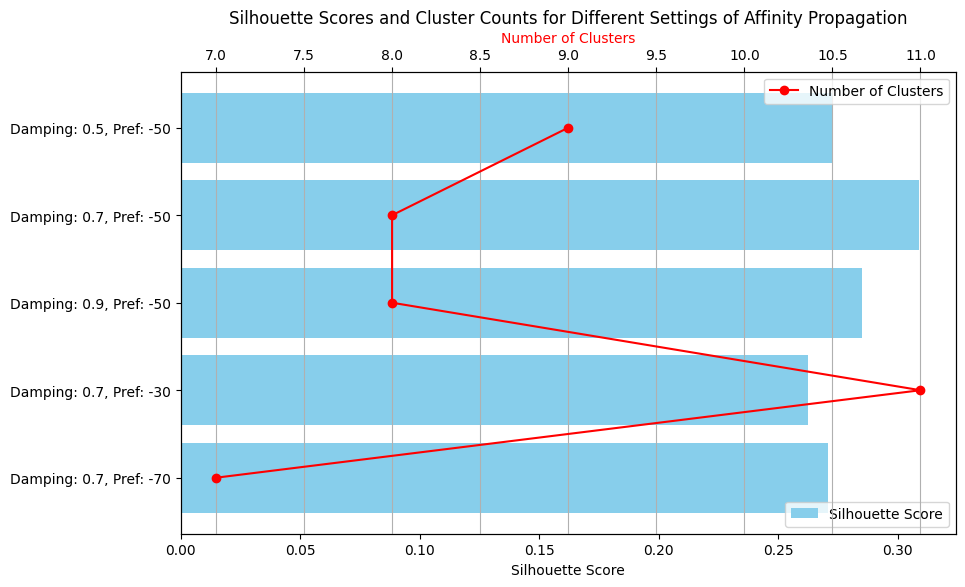

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


data = pd.read_csv('Data_Sample_Full.csv', encoding='ISO-8859-1')


data['Order Date'] = pd.to_datetime(data['Order Date'])


today = pd.to_datetime('today')
rfm_data = data.groupby('Customer ID').agg({
    'Order Date': lambda x: (today - x.max()).days,  # Recency
    'Order ID': 'count',                             # Frequency
    'Sales': 'sum'                                   # Monetary
}).reset_index().rename(columns={'Order Date':'Recency', 'Order ID':'Frequency', 'Sales':'Monetary'})


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])


parameters = [(0.5, -50), (0.7, -50), (0.9, -50), (0.7, -30), (0.7, -70)]


silhouette_scores = []
labels_list = []
cluster_counts = []
for damping, preference in parameters:
    affinity_propagation = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    labels = affinity_propagation.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    labels_list.append(f'Damping: {damping}, Pref: {preference}')
    cluster_counts.append(len(np.unique(labels)))


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.barh(labels_list, silhouette_scores, color='skyblue', label='Silhouette Score')
ax1.set_xlabel('Silhouette Score')
ax1.set_title('Silhouette Scores and Cluster Counts for Different Settings of Affinity Propagation')
ax1.invert_yaxis()


ax2 = ax1.twiny()
ax2.plot(cluster_counts, labels_list, 'ro-', label='Number of Clusters')
ax2.set_xlabel('Number of Clusters', color='red')


ax1.legend(loc='lower right')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()
